In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *

%load_ext autoreload
%autoreload 2

# recall errors

In [2]:
recall_df = load_recall_df()
wed_path_df = load_wed_path_map()

### define incorrect recall: mention state not present in path of given wedding

In [93]:
correct_states = {
  'NA':[3,5,7],'NB':[4,6,8],
  'SA':[3,6,7],'SB':[4,5,8]
}
correct_transitions = {
  'NA':['3-5','5-7'],'NB':['4-6','6-8'],
  'SA':['3-6','6-7'],'SB':['4-5','5-8']
}
wrong_states = {
  'NA':[4,6,8],'NB':[3,5,7],
  'SA':[4,5,8],'SB':[3,6,7]
}  
wrong_transitions = {
  'NA':['3-6','5-8'],'NB':['4-5','6-7'],
  'SA':['3-5','6-8'],'SB':['4-6','5-7']
}

In [237]:
# count number of correctly/incorrectly recalled states
recall_score = []
for sub,sub_recall_df in recall_df.groupby(['subject']):
  n_correct_states = 0
  n_wrong_states = 0
  n_correct_transitions = 0
  n_wrong_transitions = 0
  for wed,sub_wed_recall_df in sub_recall_df.groupby(['wedding']):
    recall_transitions = extract_recall_transitions(sub_wed_recall_df)
    recalled_states = sub_wed_recall_df.recall.unique()
    path = wed_path_df.loc[sub,int(wed[1:])]
    ## states
    n_correct_states = sum([state in correct_states[path] for state in recalled_states])
    n_wrong_states = sum([state in wrong_states[path] for state in recalled_states])
    ## 
    recall_score.append([sub,wed,n_correct_states,n_wrong_states,n_correct_transitions,n_wrong_transitions])
  None
  
recall_score = np.array(recall_score)

In [311]:
recall_counts_df = pd.DataFrame(
  index=range(len(recall_score)),data=recall_score,
  columns=['sub','wed','correct_states','wrong_states','correct_transitions','wrong_transitions'])
recall_counts_df = recall_counts_df.astype({'correct_states':int,'wrong_states':int})

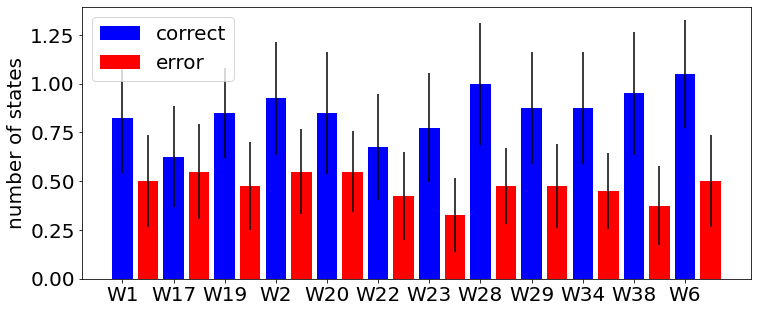

In [377]:
recall_counts_wed_df = recall_counts_df.groupby('wed')
M = recall_counts_wed_df.mean()
S = recall_counts_wed_df.std()
N = len(recall_counts_wed_df)
plt.figure(figsize=(12,5))
ax = plt.gca()
cL = ['b','r']
ML = [M.correct_states,M.wrong_states]
SL = [S.correct_states,S.wrong_states]
labL = ['correct','error']
for idx in [0,1]:
  ax.bar(np.arange(12)+0.5*idx,ML[idx],yerr=SL[idx]/np.sqrt(N),color=cL[idx],width=.4,label=labL[idx])
ax.legend()
ax.set_xticks(range(12))
ax.set_xticklabels(M.index)
ax.set_ylabel('number of states')
plt.savefig('figures/recall_by_wedding')

Text(0.5, 1.0, 'number of recall transitions\nper subject across 12 weddings\n')

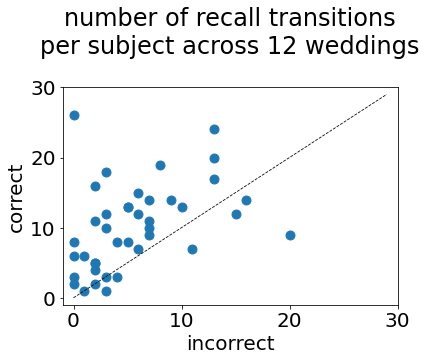

In [330]:
recall_counts_sub_df = recall_counts_df.groupby('sub').sum()
ax = plt.gca()
ax.scatter(recall_counts_sub_df.wrong_states,
           recall_counts_sub_df.correct_states,
          s=80)
ax.plot(range(30),range(30),c='k',ls='--',lw=.8)
ax.set_xlim(-1,30)
ax.set_ylim(-1,30)
ax.set_xlabel('incorrect')
ax.set_ylabel('correct')
ax.set_title('number of recall transitions\nper subject across 12 weddings\n')

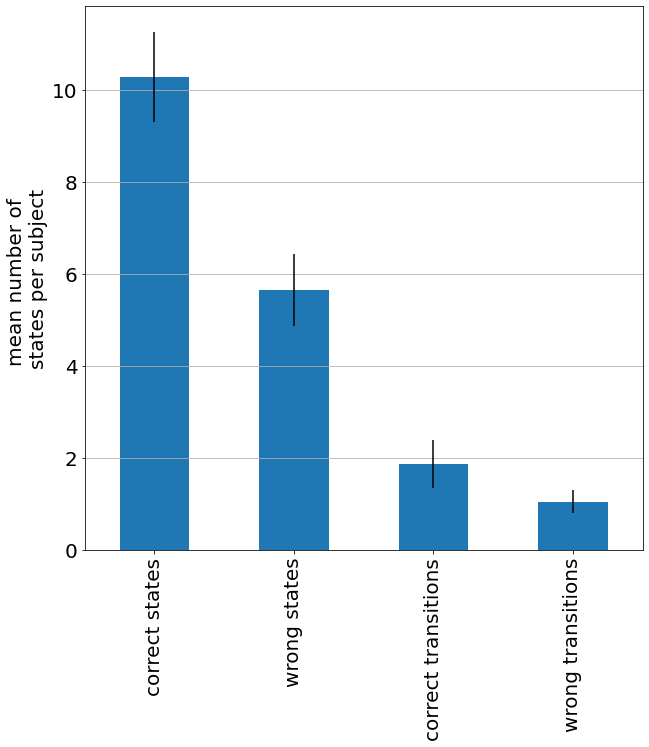

In [144]:
plt.figure(figsize=(10,10))
plt.rc('font', size=20)
ax = plt.gca()

M = recall_score_df.mean()
S = recall_score_df.std()/np.sqrt(len(recall_score_df))
# plt.figure(fig)
M.plot.bar(yerr=S,ax=ax)
ax.grid(axis='y')
ax.set_ylabel('mean number of \nstates per subject',fontsize=20)
plt.savefig('figures/first_level_recall_states')

# recall transitions

In [4]:
def extract_recall_order(sub_wed_df):
  """sub_wed_df_itr = recall_df.groupby([sub,wed])
  """
  mask = sub_wed_df.recall.values[:-1] != sub_wed_df.recall.values[1:]
  return sub_wed_df.recall.values[:-1][mask]

def extract_recall_transitions(sub_wed_df):
  """ 
  returns a list with recall transitions 
    e.g. ['2-4', '4-9', '9-8']
  """
  recall_order = extract_recall_order(sub_wed_df)
  recall_order = recall_order[np.nonzero(recall_order)]
  if len(recall_order)<2: 
    return []
  sub_trans = []
  for t in range(len(recall_order)-1):
    if recall_order[t] == recall_order[t+1]: 
      # 2 2 0 2 2 should be considered a single 2
      continue
    trans = "%i-%i"%(recall_order[t],recall_order[t+1])
    sub_trans.append(trans)
  return sub_trans


In [5]:
all_recall_transitions = []
for (sub,wed),sub_wed_df in recall_df.groupby(['subject','wedding']):
  recall_order = extract_recall_order(sub_wed_df)
  recall_transitions = extract_recall_transitions(sub_wed_df)
  all_recall_transitions.extend(recall_transitions)
  print('S%i'%sub,wed,recall_order[np.nonzero(recall_order)],recall_transitions)

S2 W1 [] []
S2 W17 [] []
S2 W19 [2] []
S2 W2 [9] []
S2 W20 [] []
S2 W22 [9] []
S2 W23 [2 3] ['2-3']
S2 W28 [9 9 2] ['9-2']
S2 W29 [2] []
S2 W34 [2] []
S2 W38 [] []
S2 W6 [2 7] ['2-7']
S3 W1 [] []
S3 W17 [2] []
S3 W19 [2 1 5 8 9] ['2-1', '1-5', '5-8', '8-9']
S3 W2 [1] []
S3 W20 [2 1 9 6 7 4 8] ['2-1', '1-9', '9-6', '6-7', '7-4', '4-8']
S3 W22 [2 9 2] ['2-9', '9-2']
S3 W23 [2] []
S3 W28 [2 4 6 8 1 9] ['2-4', '4-6', '6-8', '8-1', '1-9']
S3 W29 [2 1 3 6 7] ['2-1', '1-3', '3-6', '6-7']
S3 W34 [2 4 8 9] ['2-4', '4-8', '8-9']
S3 W38 [2 4 5 8 9] ['2-4', '4-5', '5-8', '8-9']
S3 W6 [2 1 3 9] ['2-1', '1-3', '3-9']
S4 W1 [1 3 6 8 2] ['1-3', '3-6', '6-8', '8-2']
S4 W17 [2 9 8] ['2-9', '9-8']
S4 W19 [1 4 6 7] ['1-4', '4-6', '6-7']
S4 W2 [1 4 6 4 7] ['1-4', '4-6', '6-4', '4-7']
S4 W20 [1 3 5 7 9] ['1-3', '3-5', '5-7', '7-9']
S4 W22 [4 6 8 2 1] ['4-6', '6-8', '8-2', '2-1']
S4 W23 [3 7 1 5] ['3-7', '7-1', '1-5']
S4 W28 [1 4 6 8] ['1-4', '4-6', '6-8']
S4 W29 [4 9 9] ['4-9']
S4 W34 [2 9 4 8 6 3] ['2-9', 

S35 W2 [2] []
S35 W20 [2 8 9 4 1] ['2-8', '8-9', '9-4', '4-1']
S35 W22 [2 8 9 4] ['2-8', '8-9', '9-4']
S35 W23 [] []
S35 W28 [2 4 8] ['2-4', '4-8']
S35 W29 [2 2 4] ['2-4']
S35 W34 [2 3] ['2-3']
S35 W38 [2 7 3 1] ['2-7', '7-3', '3-1']
S35 W6 [] []
S36 W1 [1] []
S36 W17 [1 2] ['1-2']
S36 W19 [1 2 2 4] ['1-2', '2-4']
S36 W2 [1 2 8] ['1-2', '2-8']
S36 W20 [1 9 5] ['1-9', '9-5']
S36 W22 [1] []
S36 W23 [1 2 5] ['1-2', '2-5']
S36 W28 [1] []
S36 W29 [1 3 6] ['1-3', '3-6']
S36 W34 [1 2 9] ['1-2', '2-9']
S36 W38 [1 2 2 2] ['1-2']
S36 W6 [1 2 2 3] ['1-2', '2-3']
S37 W1 [2 8 2 4] ['2-8', '8-2', '2-4']
S37 W17 [] []
S37 W19 [1 8 6 7 2] ['1-8', '8-6', '6-7', '7-2']
S37 W2 [2 3 1 9] ['2-3', '3-1', '1-9']
S37 W20 [] []
S37 W22 [2] []
S37 W23 [2 8] ['2-8']
S37 W28 [2 9 2 2 9] ['2-9', '9-2', '2-9']
S37 W29 [2 9 1 2] ['2-9', '9-1', '1-2']
S37 W34 [2 9 2 9 9] ['2-9', '9-2', '2-9']
S37 W38 [2 9 2 3 5 1 7] ['2-9', '9-2', '2-3', '3-5', '5-1', '1-7']
S37 W6 [2 1 3 6 7] ['2-1', '1-3', '3-6', '6-7']
S38 W1 [2 1

<AxesSubplot:>

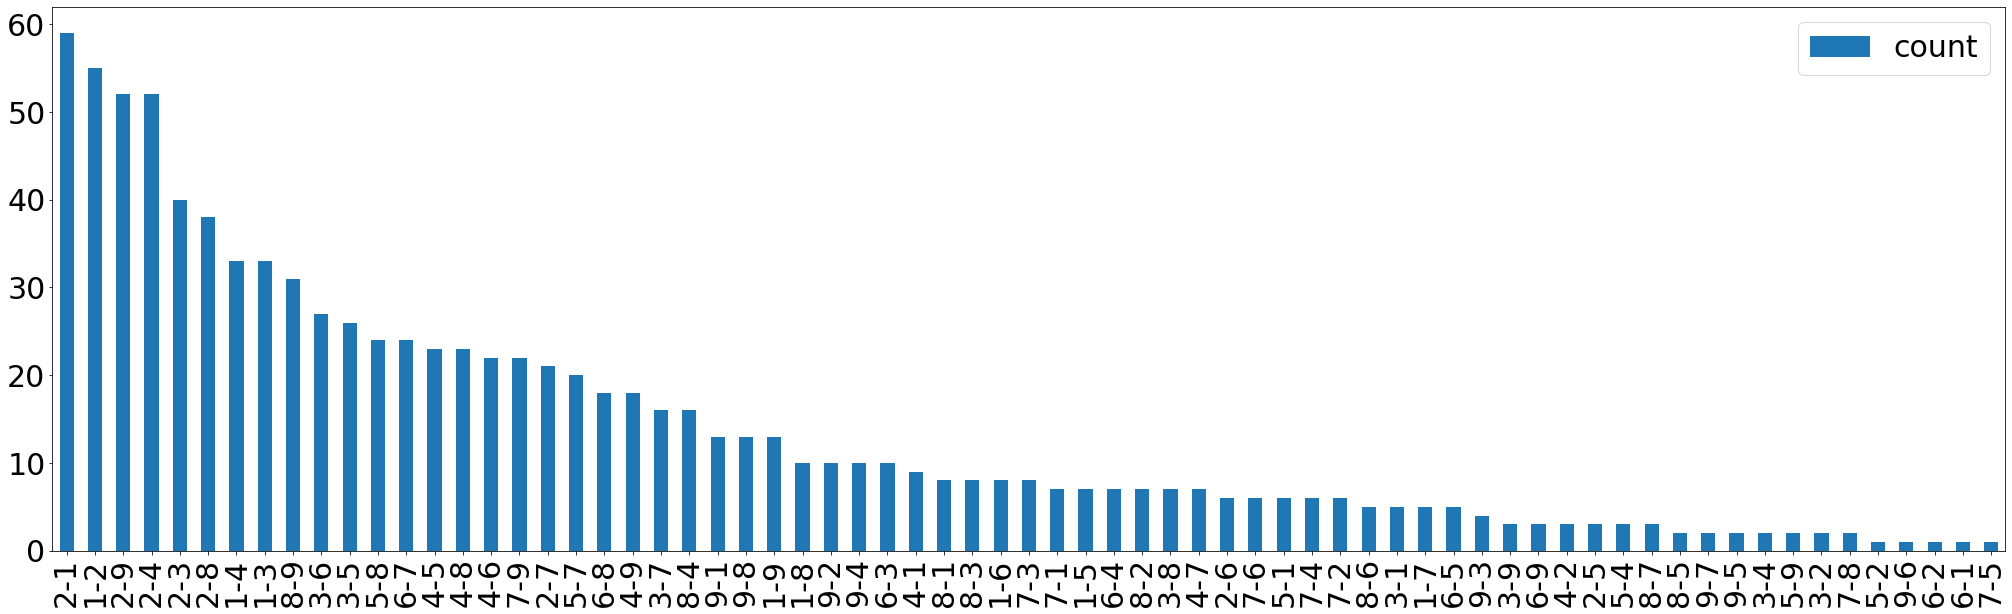

In [6]:
plt.rc('font', size=30)
from collections import Counter
transition_counts = Counter(all_recall_transitions)
transition_df = pd.DataFrame.from_dict(transition_counts,orient='index',columns=['count'])
transition_df = transition_df.sort_values('count',ascending=False)
plt.figure(figsize=(35,10))
ax = plt.gca()
transition_df.plot.bar(ax=ax)
# plt.savefig('figures/recall_transitions')

# count number of weddings where schema is mentioend

**generalize this code to every state**

Text(0.5, 0, 'subject')

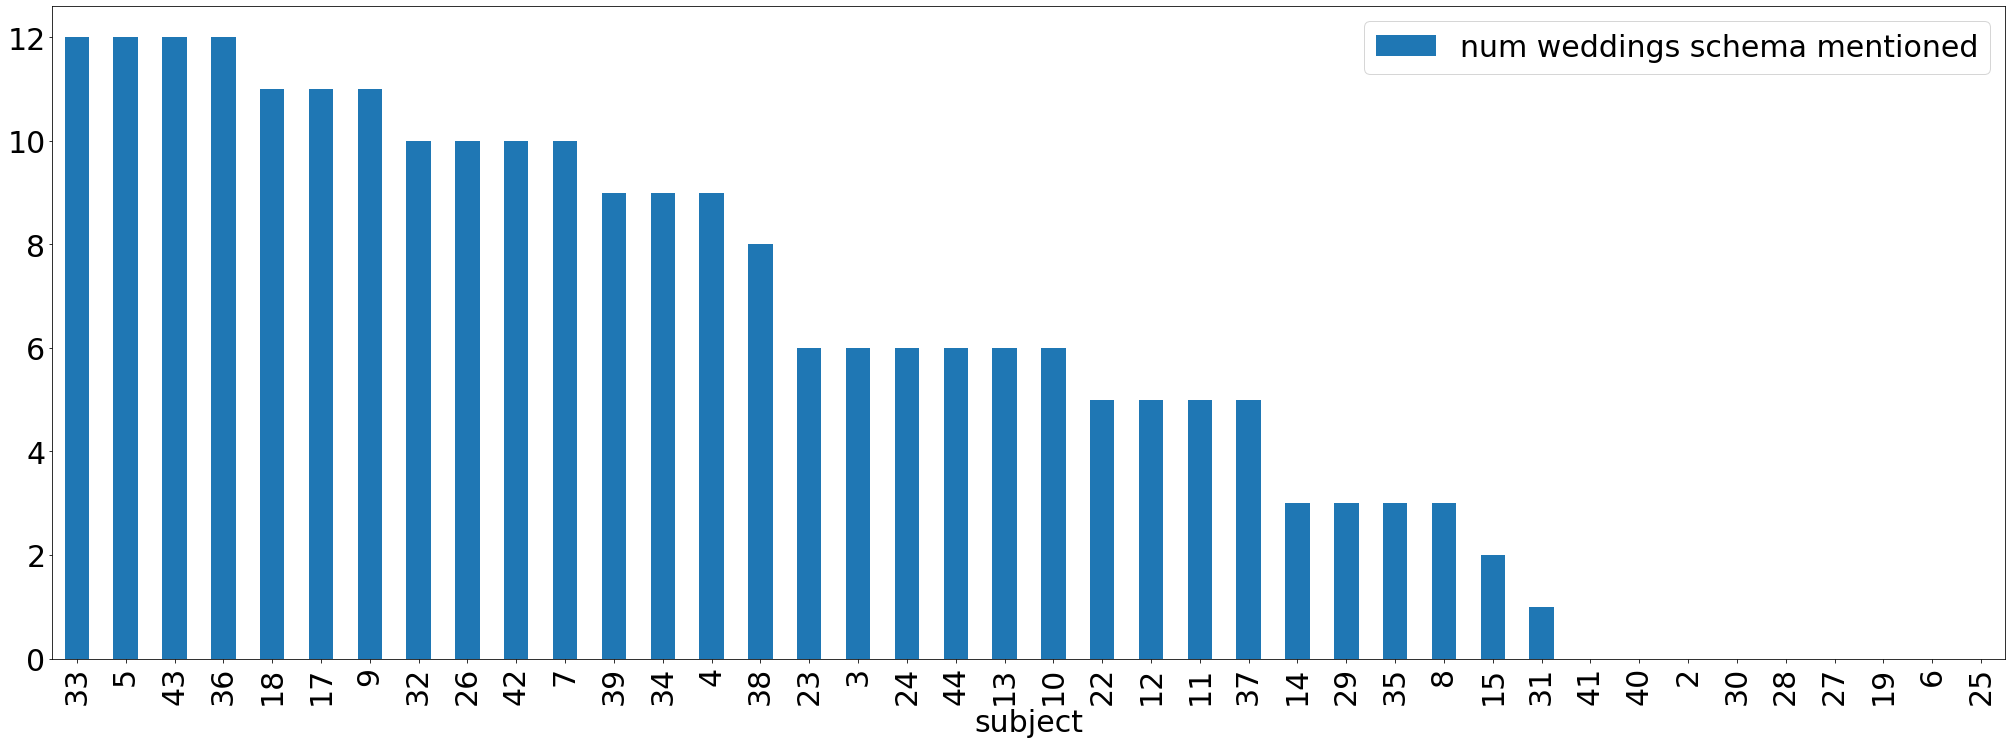

In [7]:
sub_schema_mentions_D = {}
for sub,sub_df in recall_df.groupby(['subject']):
  schema_mention_count = 0
  for wed, sub_wed_df in sub_df.groupby(['wedding']):
    schema_mention_bool = 1 in sub_wed_df.recall.unique()
    if schema_mention_bool:
      schema_mention_count += 1
  sub_schema_mentions_D[sub] = schema_mention_count
schema_mention_df = pd.DataFrame.from_dict(sub_schema_mentions_D,orient='index',
                                           columns=['num weddings schema mentioned'])
plt.figure(figsize=(35,12))
ax = plt.gca()
schema_mention_df = schema_mention_df.sort_values('num weddings schema mentioned',ascending=False)
schema_mention_df.plot.bar(ax=ax)
ax.set_xlabel('subject')
# plt.savefig('figures/schema_mentions')